# Create SUMMA forcing inputs
This script uses the intersection between catchment shapefile and ERA5 to create area-weighted forcing files for each modelling element. A lapse rate of `0.00649` `[degree C m-1]` is used to adjust temperature values based on the elevation of the ERA5 data point and the mean HRU elevation.

#### Acknowledgements
Area-weighting code is part of the CANDEX toolbox, but extracted from the main CANDEX code for clarity. CANDEX: https://github.com/ShervanGharari/candex_newgen/

In [12]:
# modules
import os
from pathlib import Path
from shutil import copyfile
from datetime import datetime

In [1]:
# modules 
# import candex - currently unused, maybe be available in future version of this script
import numpy as np
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime

#### Control file handling



In [2]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line:
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find location of the intersection shapefile

In [6]:
# Intersected shapefile path and name
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')
intersect_name = read_from_control(controlFolder/controlFile,'intersect_forcing_name')

In [7]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

#### Find the location and names of the ERA5 forcing files

In [10]:
# Path to merged ERA5 forcing
forcing_merged_path = read_from_control(controlFolder/controlFile,'forcing_merged_path')

In [11]:
# Specify default path if needed
if forcing_merged_path == 'default':
    forcing_merged_path = make_default_path('forcing/2_merged_data') # outputs a Path()
else:
    forcing_merged_path = Path(forcing_merged_path) # make sure a user-specified path is a Path()

In [20]:
# Find existing raw forcing files
files = []
for file in os.listdir(forcing_merged_path):
    if file.endswith(".nc"):
        files.append(str(forcing_merged_path) + '/' + file)
files.sort() # sorted in place

#### Find where the new forcing files need to go

In [25]:
# Path to SUMMA input forcing files
summa_input_path = read_from_control(controlFolder/controlFile,'forcing_summa_path')

In [26]:
# Specify default path if needed
if summa_input_path == 'default':
    summa_input_path = make_default_path('forcing/3_SUMMA_input') # outputs a Path()
else:
    summa_input_path = Path(summa_input_path) # make sure a user-specified path is a Path()

In [28]:
# Make the folder if it doesn't exist
summa_input_path.mkdir(parents=True, exist_ok=True)

#### Load the intersection data

In [13]:
intersect_shape = gpd.read_file( catchment_path/catchment_name )
forcing_shape   = gpd.read_file( forcing_path/forcing_name )

#### Elevation ?!

#### Get the intersection function from CANDEX

In [20]:
def intersection_shp(shp_1, shp_2):
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/candex
    @ author's email id:       sh.gharari@gmail.com
    @license:                  Apache2

    This fucntion intersect two shapefile. It keeps the fiels from the first and second shapefiles (identified by S_1_ and 
    S_2_). It also creats other field including AS1 (area of the shape element from shapefile 1), IDS1 (an arbitary index
    for the shapefile 1), AS2 (area of the shape element from shapefile 1), IDS2 (an arbitary index for the shapefile 1), 
    AINT (the area of teh intersected shapes), AP1 (the area of the intersected shape to the shapes from shapefile 1),
    AP2 (the area of teh intersected shape to the shapefes from shapefile 2), AP1N (the area normalized in the case AP1
    summation is not 1 for a given shape from shapefile 1, this will help to preseve mass if part of the shapefile are not 
    intersected), AP2N (the area normalized in the case AP2 summation is not 1 for a given shape from shapefile 2, this
    will help to preseve mass if part of the shapefile are not intersected)
    
    Arguments
    ---------
    shp1: geo data frame, shapefile 1
    shp2: geo data frame, shapefile 2
    
    Returns
    -------
    result: a geo data frame that includes the intersected shapefile and area, percent and normalized percent of each shape
    elements in another one
    """
    # Calculating the area of every shapefile (both should be in degree or meters)
    column_names = shp_1.columns
    column_names = list(column_names)

    # removing the geometry from the column names
    column_names.remove('geometry')

    # renaming the column with S_1
    for i in range(len(column_names)):
        shp_1 = shp_1.rename(
            columns={column_names[i]: 'S_1_' + column_names[i]})

    column_names = shp_2.columns
    column_names = list(column_names)

    # removing the geometry from the colomn names
    column_names.remove('geometry')

    # renaming the column with S_2
    for i in range(len(column_names)):
        shp_2 = shp_2.rename(
            columns={column_names[i]: 'S_2_' + column_names[i]})
        
    # Add the catchment centroids
    shp_1['S_1_lon_c'] = shp_1.centroid.x
    shp_1['S_1_lat_c'] = shp_1.centroid.y

    # Caclulating the area for shp1
    shp_1["AS1"] = shp_1['geometry'].area
    shp_1["IDS1"] = np.arange(1,shp_1.shape[0]+1.00)
        
    # Caclulating the area for shp2
    shp_2["AS2"] = shp_2['geometry'].area
    shp_2["IDS2"] = np.arange(1,shp_2.shape[0]+1.00)
        
    # making intesection
    result = spatial_overlays (shp_1, shp_2, how='intersection')

    # Caclulating the area for shp2
    result['AINT'] = result['geometry'].area
    result['AP1'] = result['AINT']/result['AS1']
    result['AP2'] = result['AINT']/result['AS2']
       
    # taking the part of data frame as the numpy to incread the spead
    # finding the IDs from shapefile one
    ID_S1 = np.array (result['IDS1'])
    AP1 = np.array(result['AP1'])
    AP1N = AP1 # creating the nnormalized percent area
    ID_S1_unique = np.unique(ID_S1) #unique idea
    for i in ID_S1_unique:
        INDX = np.where(ID_S1==i) # getting the indeces
        AP1N[INDX] = AP1[INDX] / AP1[INDX].sum() # normalizing for that sum
        
    # taking the part of data frame as the numpy to incread the spead
    # finding the IDs from shapefile one
    ID_S2 = np.array (result['IDS2'])
    AP2 = np.array(result['AP2'])
    AP2N = AP2 # creating the nnormalized percent area
    ID_S2_unique = np.unique(ID_S2) #unique idea
    for i in ID_S2_unique:
        INDX = np.where(ID_S2==i) # getting the indeces
        AP2N[INDX] = AP2[INDX] / AP2[INDX].sum() # normalizing for that sum
        
    result ['AP1N'] = AP1N
    result ['AP2N'] = AP2N
               
    return result

def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.
    
    Ömer Özak
    ozak
    https://github.com/ozak
    https://github.com/geopandas/geopandas/pull/338

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

#### Do the intersection

In [23]:
# Make sure the Coordinate Reference Systesm are set - should be EPSG:4326
catchment_shape.crs = {'init': 'epsg:4326'}
forcing_shape.crs = {'init': 'epsg:4326'}

In [27]:
# Do the intersection
intersected_shape = intersection_shp(catchment_shape, forcing_shape)

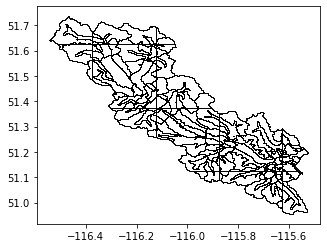

In [29]:
# Check what we got back
intersected_shape.plot(facecolor='none',edgecolor='k')

In [32]:
# Check the shape fields
intersected_shape

,S_1_GRU_ID,S_1_HRU_ID,S_1_center_lat,S_1_center_lon,S_1_HRU_area,S_1_lon_c,S_1_lat_c,AS1,IDS1,S_2_ID,...,S_2_lon,S_2_elev_m,AS2,IDS2,geometry,AINT,AP1,AP2,AP1N,AP2N
0,71028585,48,51.151817,-115.580275,5.081262e+05,-115.580275,51.151817,0.000065,1.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.57375 51.15042, -115.57375 51.1...",0.000065,1.000000,0.001044,1.000000,0.006580
1,71028585,97,51.160432,-115.575117,1.615975e+06,-115.575117,51.160432,0.000208,2.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554...",0.000208,1.000000,0.003322,1.000000,0.020931
2,71028585,118,51.172348,-115.572209,4.117252e+06,-115.572209,51.172348,0.000529,3.0,28.0,...,-115.5,2020,0.0625,28.0,"POLYGON ((-115.58792 51.17708, -115.58792 51.1...",0.000529,1.000000,0.008467,1.000000,0.053342
4,71028597,1,51.192711,-115.622019,1.620257e+06,-115.622019,51.192711,0.000208,4.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854...",0.000097,0.466667,0.001556,0.466667,0.009800
6,71028597,49,51.177476,-115.611405,3.781836e+06,-115.611405,51.177476,0.000486,5.0,28.0,...,-115.5,2020,0.0625,28.0,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845...",0.000406,0.834286,0.006489,0.834286,0.040881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,71032185,91,51.586643,-116.376476,1.544394e+07,-116.376476,51.586643,0.002003,108.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.44208 51.58208, -116.4420...",0.000948,0.473128,0.015161,0.473128,0.108949
212,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,7.0,...,-116.5,2093,0.0625,7.0,"MULTIPOLYGON (((-116.37500 51.62458, -116.3754...",0.000279,0.024671,0.004458,0.024671,0.032038
186,71032185,42,51.593968,-116.424058,5.606903e+07,-116.424058,51.593968,0.007272,107.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.44875 51.63458, -116.44708 51.6...",0.000321,0.044118,0.005133,0.044118,0.025529
211,71032440,47,51.667536,-116.451110,8.694081e+07,-116.451110,51.667536,0.011294,117.0,6.0,...,-116.5,2243,0.0625,6.0,"POLYGON ((-116.47042 51.73542, -116.46708 51.7...",0.010346,0.916026,0.165536,0.916026,0.823233


#### Save the new file

In [34]:
intersected_shape.to_file( intersect_path/intersect_name )

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [35]:
# Set the log path and file name
logPath = intersect_path
log_suffix = '_catchment_forcing_intersect_log.txt'

In [36]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [39]:
# Copy this script
thisFile = '1_intersect_catchment_with_era5.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [40]:
# Get current date and time
now = datetime.now()

In [41]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Intersect shapefiles of catchment and ERA5.']
    for txt in lines:
        file.write(txt)  

#### Possible future code
Needs to wait until CANDEX functions are modified.

In [15]:
# Make an empty CANDEX object
cndx = candex.candex()

In [16]:
# List all methods
object_methods = [method_name for method_name in dir(cndx) if callable(getattr(cndx, method_name))]
object_methods

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_candex__NetCDF_SHP_lat_lon',
 '_candex__check_candex_input',
 '_candex__check_candex_remap',
 '_candex__check_source_nc',
 '_candex__check_source_nc_shp',
 '_candex__check_target_shp',
 '_candex__create_remap',
 '_candex__create_row_col_file',
 '_candex__get_row_col',
 '_candex__intersection_shp',
 '_candex__lat_lon_SHP',
 '_candex__spatial_overlays',
 '_candex__target_nc_creation',
 '_candex__weighted_average',
 'get_col_row',
 'run_candex']

In [18]:
# Get the function we need
func_intersect = getattr(cndx, '_candex__intersection_shp')

In [19]:
# Use the intersection function
func_intersect

<bound method candex.__intersection_shp of <candex.candex.candex object at 0x000002DB5B0FEEC8>>